# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [34]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and check its columns.

In [35]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
    # return_other_fields=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Add imports.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare the dataset dataframe.
Convert APP column to APP_NAME.

In [37]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

## Feature extraction

Choose applications.

In [38]:
# apps_to_extract = ["alza-webapi", "drmax", "dns-doh", "flightradar24", "bongacams", "cloudflare-cdnjs", "playradio", "gmail", "google-recaptcha", "chrome-remotedesktop"]
apps_to_extract = ["alza-webapi", "drmax", "dns-doh"]

data_df = data_df[data_df["APP_NAME"].isin(apps_to_extract)]

Create new features.

In [39]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]
data_df["BYTES_TOTAL"] = data_df["BYTES"] + data_df["BYTES_REV"]
data_df["PACKETS_TOTAL"] = data_df["PACKETS"] + data_df["PACKETS_REV"]

Get only the columns that are needed for clustering.

In [47]:
features_to_extract = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION",
                       "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV", "BYTES_TOTAL", "PACKETS_TOTAL"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Preprocessing

Standardize the features.

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Clustering

### HDBSCAN

Cluster the data using HDBSCAN.

In [65]:
from sklearn.cluster import HDBSCAN, DBSCAN

# hdbscan = DBSCAN(min_cluster_size=5)
hdbscan = DBSCAN(eps=0.8, min_samples=5)
hdbscan.fit(preprocessed_array)

DBSCAN(eps=0.8)

Count of clusters.

In [66]:
len(np.unique(hdbscan.labels_))

5

## Evaluation

### Purity score

In [67]:
from sklearn.metrics.cluster import contingency_matrix

def purity_score(y_true, y_pred) -> float:
    cm = contingency_matrix(y_true, y_pred)

    return float(np.sum(np.amax(cm, axis=0)) / np.sum(cm))

purity_score(app_array, hdbscan.labels_)

0.6520979020979021

### NMI

In [68]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(app_array, hdbscan.labels_)

0.34351270203714795

## Visualization

### Scatter plot using PCA

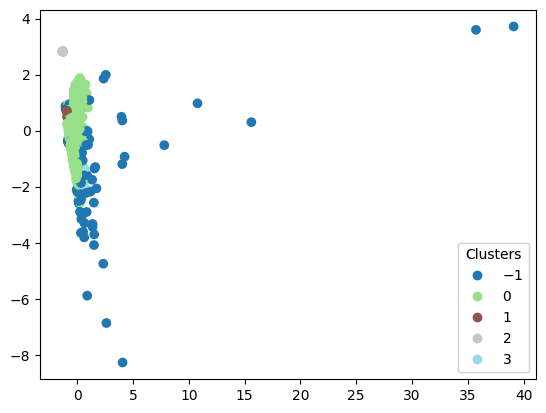

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_array = pca.fit_transform(preprocessed_array)

fig, ax = plt.subplots()
scatter = ax.scatter(pca_array[:, 0], pca_array[:, 1], c=hdbscan.labels_, cmap="tab20")
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()